In [1]:
import tensorflow as tf

print(tf.__version__)

2.6.0


In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Downloading a pretained model

In [3]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!curl -O https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 83.8M    0 15124    0     0  36159      0  0:40:31 --:--:--  0:40:31 36268
  6 83.8M    6 5661k    0     0  4203k      0  0:00:20  0:00:01  0:00:19 4209k
 24 83.8M   24 20.6M    0     0  8993k      0  0:00:09  0:00:02  0:00:07 8998k
 43 83.8M   43 36.3M    0     0  10.8M      0  0:00:07  0:00:03  0:00:04 10.8M
 62 83.8M   62 52.5M    0     0  12.0M      0  0:00:06  0:00:04  0:00:02 12.0M
 80 83.8M   80 67.5M    0     0  12.6M      0  0:00:06  0:00:05  0:00:01 13.7M
 96 83.8M   96 80.9M    0     0  12.7M      0  0:00:06  0:00:06 --:--:-- 15.0M
100 83.8M  100 83.8M    0     0  12.7M      0  0:00:06  0:00:06 --:--:-- 15.0M


> ### Initializing weights

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import os

this_dir = os.getcwd()
this_file = os.path.join(this_dir, "SC2_W3_TransferLearning.ipynb")
weights_file = os.path.join(this_dir, "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

pretrained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

pretrained_model.load_weights(weights_file)

#Freezing weights of layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [6]:
#we choose the las layer
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print(last_output)
pretrained_model.summary()

last layer output shape:  (None, 7, 7, 768)
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
________________________________________________________________________________________

In [7]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)      

# Append the dense network to the base model
model = Model(pretrained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

## Prepare training data

In [9]:
!curl -O "https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip" 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 65.4M    1  782k    0     0   928k      0  0:01:12 --:--:--  0:01:12  930k
 24 65.4M   24 15.8M    0     0  8828k      0  0:00:07  0:00:01  0:00:06 8837k
 53 65.4M   53 35.2M    0     0  12.3M      0  0:00:05  0:00:02  0:00:03 12.4M
 83 65.4M   83 54.8M    0     0  14.2M      0  0:00:04  0:00:03  0:00:01 14.2M
100 65.4M  100 65.4M    0     0  14.7M      0  0:00:04  0:00:04 --:--:-- 14.7M


In [10]:
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_f = zipfile.ZipFile("cats_and_dogs_filtered.zip", 'r')
zip_f.extractall("tmp/")
zip_f.close()

images_base = "tmp/cats_and_dogs_filtered"
training_dir = os.path.join(this_dir, "tmp", "cats_and_dogs_filtered", "train")
validation_dir = os.path.join(this_dir, "tmp", "cats_and_dogs_filtered", "validation")

train_cats_dir = os.path.join(training_dir, "cats")
train_dogs_dir = os.path.join(training_dir, "dogs")
val_cats_dir = os.path.join(validation_dir, "cats")
val_dogs_dir = os.path.join(validation_dir, "dogs")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size=20,
    class_mode="binary",
    target_size=(150, 150)
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode="binary",
    target_size=(150,150),
)

Found 2001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
)

Epoch 1/20
100/100 [==============================] - 19s 188ms/step - loss: 0.2614 - accuracy: 0.8905 - val_loss: 0.1246 - val_accuracy: 0.9560
Epoch 2/20
100/100 [==============================] - 9s 94ms/step - loss: 0.2231 - accuracy: 0.9101 - val_loss: 0.1249 - val_accuracy: 0.9520
Epoch 3/20
100/100 [==============================] - 10s 99ms/step - loss: 0.2032 - accuracy: 0.9324 - val_loss: 0.1288 - val_accuracy: 0.9540
Epoch 4/20
100/100 [==============================] - 10s 98ms/step - loss: 0.1978 - accuracy: 0.9293 - val_loss: 0.0997 - val_accuracy: 0.9650
Epoch 5/20
100/100 [==============================] - 10s 96ms/step - loss: 0.1891 - accuracy: 0.9313 - val_loss: 0.1357 - val_accuracy: 0.9590
Epoch 6/20
100/100 [==============================] - 10s 96ms/step - loss: 0.1748 - accuracy: 0.9364 - val_loss: 0.1128 - val_accuracy: 0.9600
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 0.1824 - accuracy: 0.9349 - val_loss: 0.1486 - val_accuracy:

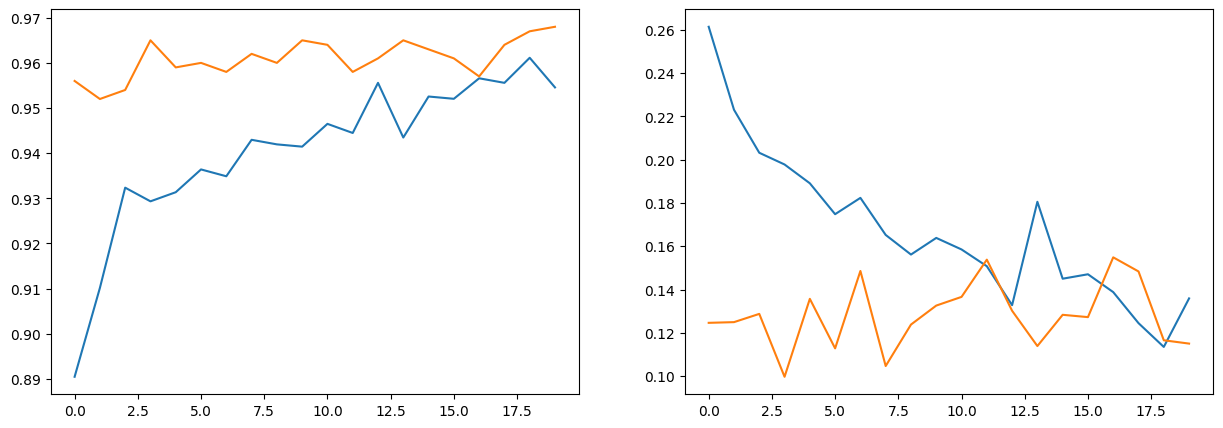

In [23]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
valacc = history.history["val_accuracy"]
loss = history.history["loss"]
valloss = history.history["val_loss"]

epochs = range(len(acc))
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

axs[0].plot(epochs, acc)
axs[0].plot(epochs, valacc)
axs[1].plot(epochs, loss)
axs[1].plot(epochs, valloss)